In [1]:
import os
import sys
from getpass import getpass
import pathlib
import json
import pandas as pd
import numpy as np
import csv
from time import time

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from tqdm.notebook import tqdm
from typing import List

LOCAL_PATH = "/tmp/patent-analysis"
DATA_PATH = os.path.join(LOCAL_PATH, 'dataset')
PERMANENT_STORAGE = "/patent-analysis/dataset"

sys.path.append(LOCAL_PATH)

import dask.dataframe as dask
from dask.distributed import Client

from utils.stats import print_ddf_stats

In [2]:
ncpus = len(os.sched_getaffinity(0))
print("Number of CPUs available:", ncpus)
client = Client(n_workers=32, threads_per_worker=2, memory_limit='7GB', dashboard_address='6006')
client

Number of CPUs available: 64


Client Scheduler: tcp://127.0.0.1:45917 Dashboard: http://127.0.0.1:6006/status,Cluster Workers: 32 Cores: 64 Memory: 224.00 GB


In [3]:
ddf = dask.read_parquet("/patent-analysis/datasets/api/*-patent.parquet")

In [4]:
ddf.head()

,patent_title,patent_date,patent_kind,patent_type,inventor_id,inventor_first_name,inventor_last_name,inventor_location_id,inventor_city,inventor_state,...,assignee_longitude,assignee_sequence,assignee_type,assignee_key_id,cpc_section_id,cpc_subsection_id,cpc_group_id,cpc_subgroup_id,cpc_category,cpc_sequence
3930271,Golf glove,1976-01-06,A,utility,None,None,None,None,None,None,...,-87.65,0,2,411208,A,A63,A63B,A63B71/146,inventional,0
3930272,Crib leg lock,1976-01-06,A,utility,None,None,None,None,None,None,...,-78.5042,0,2,110820,A,A47,A47D,A47D7/02,inventional,0
3930272,Crib leg lock,1976-01-06,A,utility,None,None,None,None,None,None,...,-78.5042,0,2,110820,Y,Y10,Y10T,Y10T403/32451,additional,1
3930273,Bed safety side rail arrangement,1976-01-06,A,utility,3930273-1,Robert,Stern,38.627|-90.1994,St. Louis,MO,...,-90.1994,0,2,432504,A,A61,A61G,A61G7/0507,inventional,0
3930273,Bed safety side rail arrangement,1976-01-06,A,utility,3930273-1,Robert,Stern,38.627|-90.1994,St. Louis,MO,...,-90.1994,0,2,432504,A,A61,A61G,A61G7/0509,inventional,1


In [5]:
len(ddf)

124707016

In [6]:
ddf.columns

Index(['patent_title', 'patent_date', 'patent_kind', 'patent_type',
       'inventor_id', 'inventor_first_name', 'inventor_last_name',
       'inventor_location_id', 'inventor_city', 'inventor_state',
       'inventor_country', 'inventor_latitude', 'inventor_longitude',
       'inventor_sequence', 'inventor_key_id', 'assignee_id',
       'assignee_organization', 'assignee_first_name', 'assignee_last_name',
       'assignee_location_id', 'assignee_city', 'assignee_state',
       'assignee_country', 'assignee_latitude', 'assignee_longitude',
       'assignee_sequence', 'assignee_type', 'assignee_key_id',
       'cpc_section_id', 'cpc_subsection_id', 'cpc_group_id',
       'cpc_subgroup_id', 'cpc_category', 'cpc_sequence'],
      dtype='object')

## Plot the pie-chart of the patent distribution per assignee

In [11]:
assignee_country_counts = ddf.map_partitions(lambda x: x.groupby(x.index)['assignee_country'].first()).compute()
assignee_country_counts = assignee_country_counts.value_counts()
assignee_country_counts

US    3409663
JP    1305627
DE     394096
KR     272642
TW     179238
       ...   
NM          1
WF          1
VA          1
ZW          1
CT          1
Name: assignee_country, Length: 206, dtype: int64

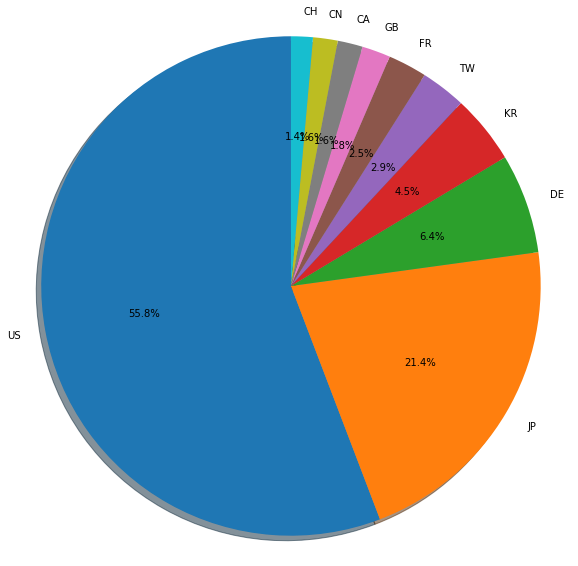

In [12]:
x = dict(100 * assignee_country_counts[:10] / assignee_country_counts.values.sum())


fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(x.values(), labels=x.keys(), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

## Plot the pie-chart of the patent distribution per inventor

In [14]:
inventor_country_counts = ddf.map_partitions(lambda x: x.groupby(x.index)['inventor_country'].first()).compute()
inventor_country_counts = inventor_country_counts.value_counts()
inventor_country_counts

US    3900358
JP    1322331
DE     445344
KR     274496
TW     221435
       ...   
TS          1
ER          1
LY          1
RC          1
OK          1
Name: inventor_country, Length: 240, dtype: int64

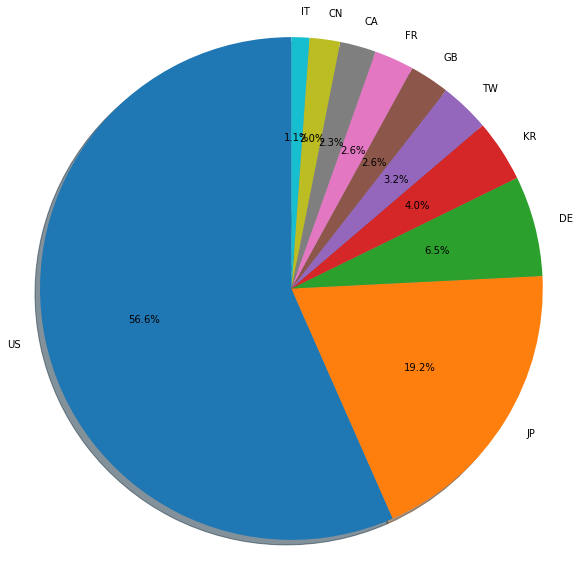

In [15]:
x = dict(100 * inventor_country_counts[:10] / inventor_country_counts.values.sum())


fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(x.values(), labels=x.keys(), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

## Plot distribution of patent types and kinds

In [17]:
patent_type = ddf.map_partitions(lambda x: x.groupby(x.index)['patent_type'].first()).compute()
patent_type = patent_type.value_counts()
patent_type

utility                             6824356
design                               654231
plant                                 28219
reissue                               19386
statutory invention registration       2259
defensive publication                   509
TVPP                                      3
Name: patent_type, dtype: int64

In [18]:
patent_kind= ddf.map_partitions(lambda x: x.groupby(x.index)['patent_kind'].first()).compute()
patent_kind = patent_kind.value_counts()
patent_kind

B2    3781915
A     2391379
B1     651063
S1     444649
S      209582
P2      13549
E1      10694
E        8692
P        8282
P3       6388
H        1982
I4        509
H1        273
H2          3
I5          3
Name: patent_kind, dtype: int64

## The distribution of the number of inventors per patent

         inventor_id
3930271            0
3930272            0
3930273            1
3930274            1
3930275            1
...              ...
RE48230           10
RE48231            6
RE48232            8
RE48233            3
RE48234            5

[7528963 rows x 1 columns]


<AxesSubplot:ylabel='Count'>

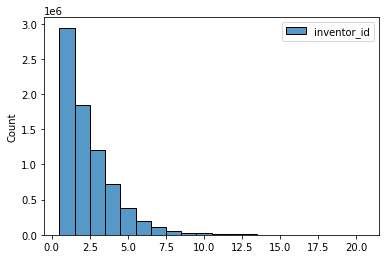

In [19]:
inventor_counts = ddf.map_partitions(lambda x: x.groupby(x.index).agg({'inventor_id': "nunique"})).compute()

print(inventor_counts)
sns.histplot(inventor_counts, bins=20, binrange=(1,20), discrete=True)

## The evolution of percentage of patents with a given number of inventor and a given number of geo-locations (cities) involved

In [41]:
geo_counts_time = ddf.map_partitions(lambda x: x.groupby(x.index).agg({'patent_date': 'first', 
                                                                        'inventor_state': "nunique", 
                                                                        'inventor_city': "nunique", 
                                                                        'inventor_id': "nunique"})).compute()
geo_counts_time['year'] = geo_counts_time['patent_date'].dt.year

In [43]:
inventor_counts_time = geo_counts_time.groupby('year')['inventor_id'].value_counts(normalize=True).to_frame()
inventor_counts_time = inventor_counts_time.rename(columns={'inventor_id': 'proportion'}).reset_index()
inventor_counts_time = inventor_counts_time.rename(columns={'inventor_id': 'inventor_count'})
inventor_counts_time = inventor_counts_time.groupby(['inventor_count', 'year']).agg({'proportion': 'first'})

city_counts_time = geo_counts_time.groupby('year')['inventor_city'].value_counts(normalize=True).to_frame()
city_counts_time = city_counts_time.rename(columns={'inventor_city': 'proportion'}).reset_index()
city_counts_time = city_counts_time.rename(columns={'inventor_city': 'city_count'})
city_counts_time = city_counts_time.groupby(['city_count', 'year']).agg({'proportion': 'first'})

inventor_counts_time.head()

proportion
inventor_count year            
0              1976    0.000479
               1977    0.000129
               1978    0.000170
               1979    0.000171
               1980    0.000362

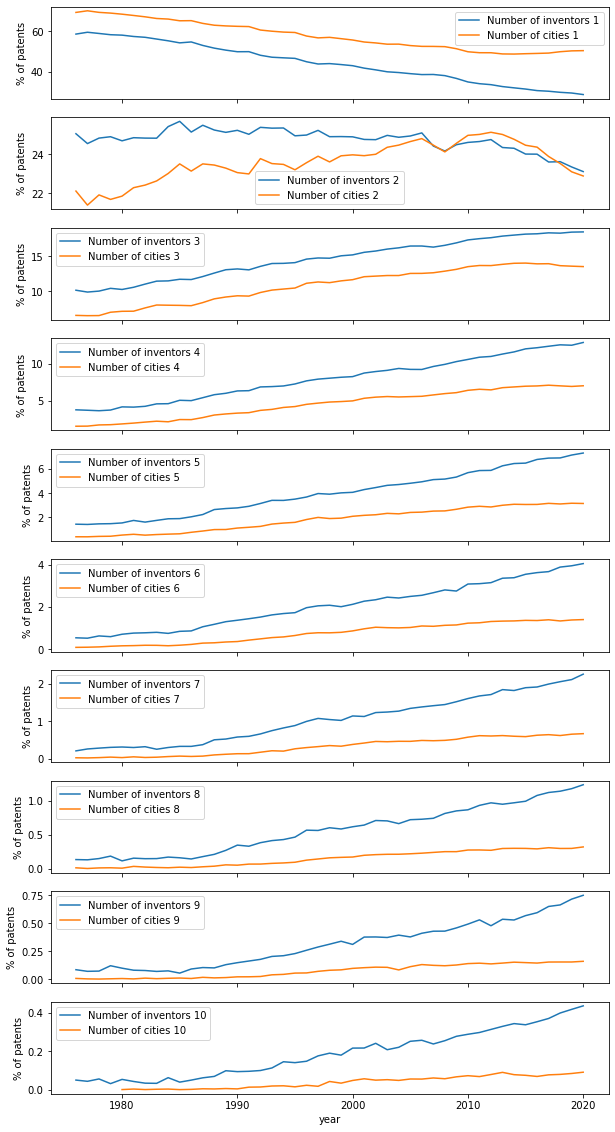

In [44]:
fig, axes = plt.subplots(10, 1, figsize=(10, 20), sharex=True, sharey=False)

for i, count in enumerate(range(1, 11)):
    (100*inventor_counts_time.loc[count] ).plot(ax=axes[i])
    (100*city_counts_time.loc[count] ).plot(ax=axes[i])
    axes[i].legend([f"Number of inventors {i+1}", f"Number of cities {i+1}"])
    axes[i].set_ylabel("% of patents")
    axes[i].set_xlabel("year")

## The distribution of the number of 4-character CPC codes per patent

         cpc_group_id
3930271             1
3930272             2
3930273             1
3930274             1
3930275             5
...               ...
RE48230             0
RE48231             0
RE48232             0
RE48233             0
RE48234             0

[7528963 rows x 1 columns]


<AxesSubplot:ylabel='Count'>

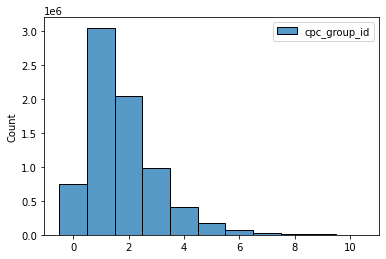

In [47]:
cpc4_code_counts = ddf.map_partitions(lambda x: x.groupby(x.index).agg({'cpc_group_id': "nunique"})).compute()

print(cpc4_code_counts)
sns.histplot(cpc4_code_counts, bins=11, binrange=(0,10), discrete=True)

## The evolution of percentage of patents with a given number of CPC4 codes

In [50]:
cpc4_code_counts_time = ddf.map_partitions(lambda x: x.groupby(x.index).agg({'patent_date': 'first',
                                                                              'cpc_group_id': "nunique"})).compute()
cpc4_code_counts_time['year'] = cpc4_code_counts_time['patent_date'].dt.year

In [51]:
cpc4_code_counts_time = cpc4_code_counts_time.groupby('year')['cpc_group_id'].value_counts(normalize=True).to_frame()
cpc4_code_counts_time = cpc4_code_counts_time.rename(columns={'cpc_group_id': 'proportion'}).reset_index()
cpc4_code_counts_time = cpc4_code_counts_time.rename(columns={'cpc_group_id': 'CPC4_count'})
cpc4_code_counts_time = cpc4_code_counts_time.groupby(['CPC4_count', 'year']).agg({'proportion': 'first'})
cpc4_code_counts_time

proportion
CPC4_count year            
0          1976    0.013039
           1977    0.068032
           1978    0.065027
           1979    0.070174
           1980    0.066785
...                     ...
30         2017    0.000009
           2018    0.000032
           2019    0.000038
           2020    0.000017
38         2020    0.000003

[850 rows x 1 columns]

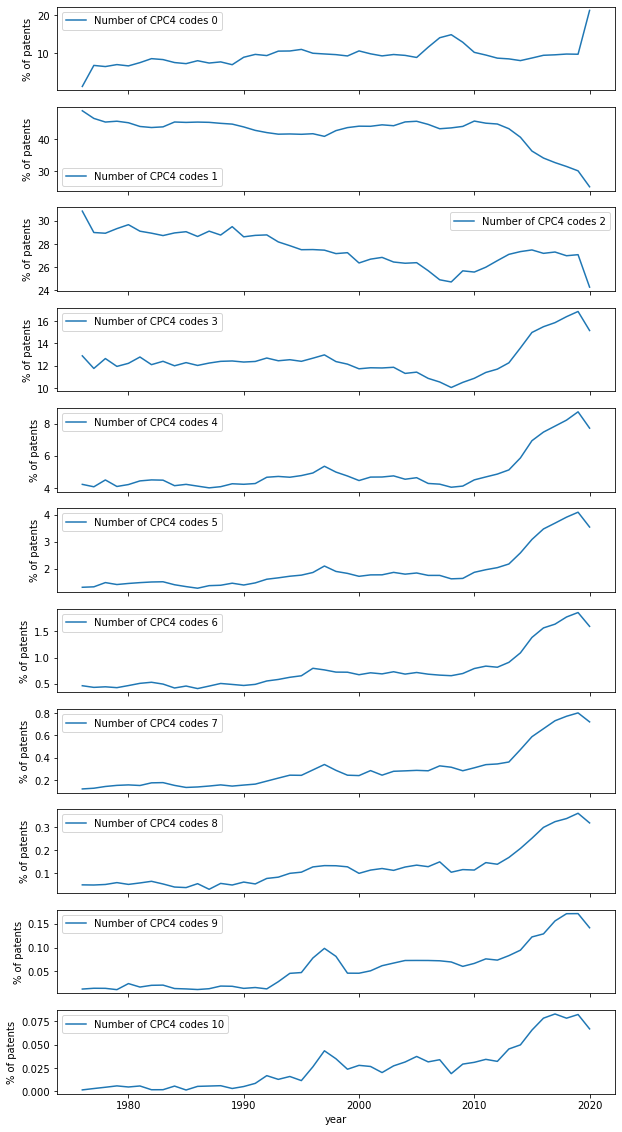

In [53]:
fig, axes = plt.subplots(11, 1, figsize=(10, 20), sharex=True, sharey=False)

for i, count in enumerate(range(0, 11)):
    (100*cpc4_code_counts_time.loc[count] ).plot(ax=axes[i])
    axes[i].legend([f"Number of CPC4 codes {i}"])
    axes[i].set_ylabel("% of patents")
    axes[i].set_xlabel("year")

## The distribution of patents across CPC4 codes

In [60]:
CPC4_code_counts = ddf.map_partitions(lambda x: x.reset_index()[['index', 'cpc_group_id']].drop_duplicates().\
                                     groupby('cpc_group_id').nunique()).compute()
CPC4_code_counts = CPC4_code_counts.groupby('cpc_group_id').sum().sort_values('index', ascending=False)


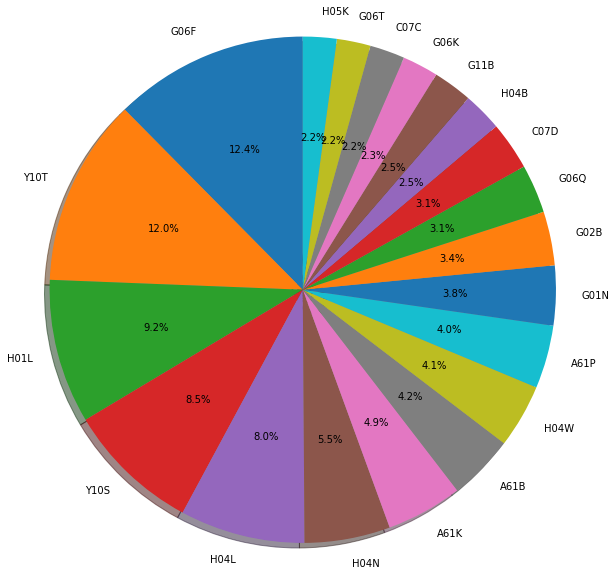

In [63]:
x = dict(100 * CPC4_code_counts['index'][:20] / CPC4_code_counts.values.sum())

fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(x.values(), labels=x.keys(), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

<AxesSubplot:xlabel='cpc_group_id', ylabel='index'>

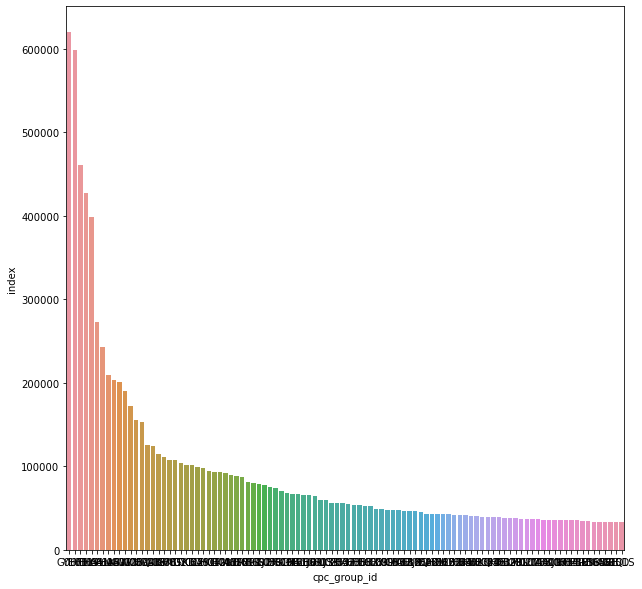

In [64]:
fig1, ax1 = plt.subplots(figsize=(10,10))
sns.barplot(x='cpc_group_id', y='index', 
            data=CPC4_code_counts.reset_index()[:100])

## The distribution of years when a CPC4 group first appeared

<AxesSubplot:xlabel='index', ylabel='year'>

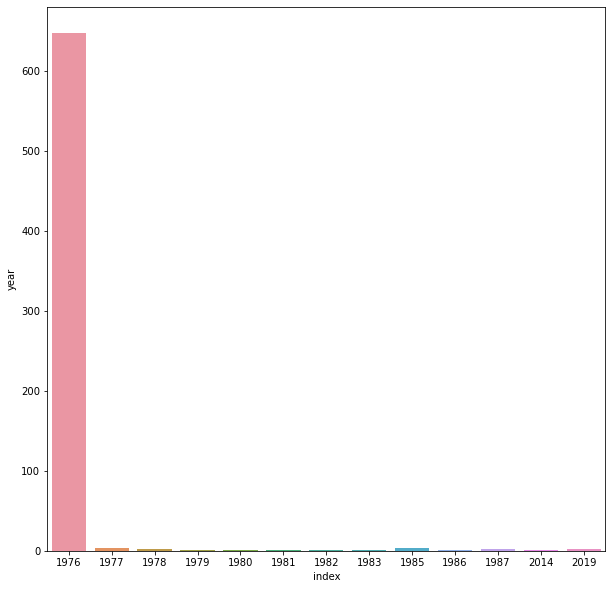

In [67]:
CPC4_code_appearance = ddf.map_partitions(lambda x: x[['cpc_group_id', 'patent_date']].drop_duplicates().\
                                     groupby('cpc_group_id').min()).compute()
CPC4_code_appearance['year'] = CPC4_code_appearance['patent_date'].dt.year

CPC4_code_appearance = CPC4_code_appearance.groupby('cpc_group_id').year.min()

fig1, ax1 = plt.subplots(figsize=(10,10))
sns.barplot(x='index', y='year', 
            data=CPC4_code_appearance.value_counts().to_frame().reset_index())

## The appearance of new CPC4 codes over time

In [68]:
ddf['cpc_subgroup_id'].unique().compute()

0             A63B71/146
1               A47D7/02
2          Y10T403/32451
3             A61G7/0507
4             A61G7/0509
               ...      
240749    G05B2219/40481
240750         G06F16/65
240751         B01D23/10
240752       B01D33/0035
240753          H04Q5/14
Name: cpc_subgroup_id, Length: 240754, dtype: object

In [73]:
CPCFULL_code_appearance = ddf.map_partitions(lambda x: x[['cpc_subgroup_id', 'patent_date']].drop_duplicates().\
                                     groupby('cpc_subgroup_id').min()).compute()

CPCFULL_code_appearance = CPCFULL_code_appearance.groupby('cpc_subgroup_id').min()
CPCFULL_code_appearance['patent_date'] = CPCFULL_code_appearance['patent_date'] +  pd.offsets.MonthBegin(0)
CPCFULL_code_appearance = CPCFULL_code_appearance.value_counts().to_frame().sort_index()

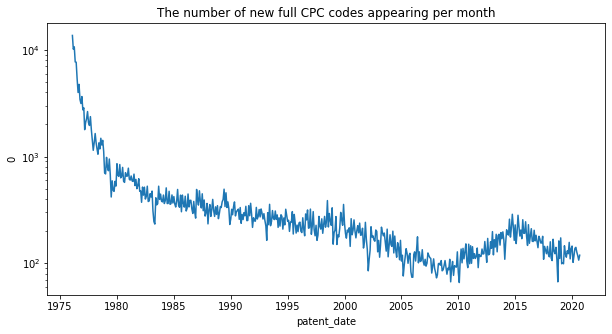

In [74]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=CPCFULL_code_appearance.reset_index(), x="patent_date", y=0)
plt.yscale('log')
plt.title("The number of new full CPC codes appearing per month")
print()

## The appearance of new full CPC codes over time, grouped by largest CPC4 codes

In [75]:
CPCFULL_code_appearance_stacked = ddf.map_partitions(lambda x: x[['cpc_subgroup_id', 'patent_date']].drop_duplicates().\
                                     groupby('cpc_subgroup_id').min()).compute()
CPCFULL_code_appearance_stacked = CPCFULL_code_appearance_stacked.groupby('cpc_subgroup_id').min()
CPCFULL_code_appearance_stacked['year'] = CPCFULL_code_appearance_stacked['patent_date'].dt.year

CPCFULL_code_appearance_stacked = CPCFULL_code_appearance_stacked.join(
                                    ddf.groupby('cpc_subgroup_id')['cpc_group_id'].first().compute())
CPCFULL_code_appearance_stacked = CPCFULL_code_appearance_stacked[['year', 'cpc_group_id']].value_counts()
CPCFULL_code_appearance_stacked


year  cpc_group_id
1976  Y10T            5163
      Y10S            2664
      B29C            1617
      C07C            1523
      B65D            1322
                      ... 
1985  B82B               1
2003  G04G               1
1985  C01C               1
      C01D               1
2020  Y10S               1
Length: 17843, dtype: int64

In [77]:
top_groups_all = ['"'+str(c)+'"' for c in CPCFULL_code_appearance_stacked.groupby('group_id').sum().sort_values(ascending=False)[:10].index.values]


top_groups_1970 = ['"'+str(c)+'"' for c in CPCFULL_code_appearance_stacked.to_frame().query(f"year >= 1970 & year < 1980").groupby('group_id').sum().sort_values(by=0, ascending=False)[:10].index.values]
top_groups_1980 = ['"'+str(c)+'"' for c in CPCFULL_code_appearance_stacked.to_frame().query(f"year >= 1980 & year < 1990").groupby('group_id').sum().sort_values(by=0, ascending=False)[:10].index.values]
top_groups_1990 = ['"'+str(c)+'"' for c in CPCFULL_code_appearance_stacked.to_frame().query(f"year >= 1990 & year < 2000").groupby('group_id').sum().sort_values(by=0, ascending=False)[:10].index.values]
top_groups_2000 = ['"'+str(c)+'"' for c in CPCFULL_code_appearance_stacked.to_frame().query(f"year >= 2000 & year < 2010").groupby('group_id').sum().sort_values(by=0, ascending=False)[:10].index.values]
top_groups_2010 = ['"'+str(c)+'"' for c in CPCFULL_code_appearance_stacked.to_frame().query(f"year >= 2010 & year < 2020").groupby('group_id').sum().sort_values(by=0, ascending=False)[:10].index.values]

top_groups_all = []
top_groups_all = set(top_groups_all + top_groups_1970 + top_groups_1980 + top_groups_1990 + top_groups_2000 + top_groups_2010)
# only preserve top 20
top_groups_all = list(top_groups_all)[:20]
top_groups_all = ",".join(top_groups_all)
top_groups_all

CPCFULL_code_appearance_stacked_top = CPCFULL_code_appearance_stacked.to_frame().query(f"group_id in [{top_groups_all}]")
CPCFULL_code_appearance_stacked_top = CPCFULL_code_appearance_stacked_top.unstack()
CPCFULL_code_appearance_stacked_top

0                                                               \
group_id    Y10T    Y10S    B29C    C07C    B65D    H01L   B01D   G01N   B65H   
year                                                                            
1976      5163.0  2664.0  1617.0  1523.0  1322.0  1234.0  987.0  978.0  820.0   
1977      1316.0   686.0   399.0   299.0   318.0   396.0  251.0  271.0  240.0   
1978       703.0   366.0   241.0   181.0   205.0   205.0  169.0  170.0  112.0   
1979       329.0   197.0   124.0   107.0   136.0   160.0   98.0  123.0  101.0   
1980       355.0   189.0   109.0   124.0   141.0   159.0   86.0   96.0  100.0   
1981       282.0   163.0   105.0    86.0    71.0   122.0   98.0  123.0   61.0   
1982       170.0   103.0    87.0    69.0    49.0   115.0   57.0   79.0   70.0   
1983       134.0    95.0    93.0    68.0    49.0    95.0   47.0   74.0   54.0   
1984       138.0    96.0    70.0    66.0    52.0   107.0   43.0   90.0   75.0   
1985       126.0    96.0    62.0    65.0    54.0   136.0   35.0   89.0   59.0   
1986       116.0    90.0    57.0    47.0    33.0   111.0   38.0   76.0   63.0   
1987        92.0   100.0    64.0    47.0    32.0    93.0   29.0  109.0   52.0   
1988        71.0    65.0    55.0    36.0    49.0   119.0   38.0   91.0   42.0   
1989        63.0    94.0    62.0    95.0    53.0   156.0   34.0  108.0   50.0   
1990        38.0    96.0    48.0    81.0    34.0   127.0   17.0   83.0   38.0   
1991        50.0    58.0    45.0    73.0    32.0   137.0   29.0   93.0   52.0   
1992        40.0    64.0    56.0    82.0    31.0   157.0   18.0   72.0   30.0   
1993        27.0    46.0    58.0    37.0    30.0    96.0   35.0   69.0   42.0   
1994        21.0    57.0    48.0    22.0    20.0   112.0   13.0   56.0   57.0   
1995        22.0    32.0    49.0    24.0    33.0    77.0   12.0   52.0   35.0   
1996        31.0    44.0    32.0    19.0    14.0    79.0   24.0   35.0   39.0   
1997        26.0    33.0    33.0    23.0    20.0   105.0   19.0   53.0   36.0   
1998        29.0    50.0    38.0    21.0    18.0   109.0   22.0   71.0   47.0   
1999        22.0    47.0    44.0    17.0    24.0   118.0   15.0   69.0   76.0   
2000        18.0    20.0    46.0    12.0    24.0    98.0   14.0   37.0   96.0   
2001         8.0    24.0    54.0    16.0    17.0   121.0   12.0   41.0   75.0   
2002        19.0    21.0    35.0    14.0    19.0    90.0   13.0   38.0   58.0   
2003        18.0    15.0    35.0    14.0    12.0   104.0    5.0   35.0   71.0   
2004        13.0    19.0    37.0     6.0     9.0   109.0   11.0   35.0   47.0   
2005        10.0    10.0    20.0     9.0    12.0   100.0    7.0   20.0   24.0   
2006         8.0     7.0    28.0    12.0     9.0    84.0   11.0   25.0   20.0   
2007        13.0     8.0    28.0     3.0    10.0    83.0    3.0   25.0   23.0   
2008         6.0    19.0    16.0     7.0     8.0    92.0   10.0   26.0   19.0   
2009         8.0    11.0    20.0     4.0     6.0   116.0   16.0   23.0   16.0   
2010         4.0    27.0    24.0     9.0    18.0   117.0   15.0   33.0   21.0   
2011         9.0    16.0    13.0     6.0    11.0   122.0   19.0   25.0   29.0   
2012         9.0    10.0    21.0     6.0    17.0   172.0   23.0   18.0   22.0   
2013         5.0    26.0    28.0     7.0    28.0   263.0   26.0   23.0   24.0   
2014         5.0    32.0    47.0    14.0    22.0   323.0   29.0   34.0   28.0   
2015         9.0    19.0    46.0    19.0    24.0   263.0   17.0   25.0   32.0   
2016         5.0     4.0    38.0    13.0    27.0   229.0   24.0   23.0   28.0   
2017         5.0     8.0    40.0    11.0    19.0   168.0   20.0   17.0   22.0   
2018         1.0     5.0    20.0    13.0    17.0   146.0   10.0   16.0   20.0   
2019         2.0     3.0    20.0    10.0    18.0   145.0    8.0   15.0   14.0   
2020         NaN     1.0     9.0     7.0     9.0   113.0   15.0    8.0    7.0   

                                                                         \
group_id   H01H   A61B   A61F   A61K   H04N   G06F 

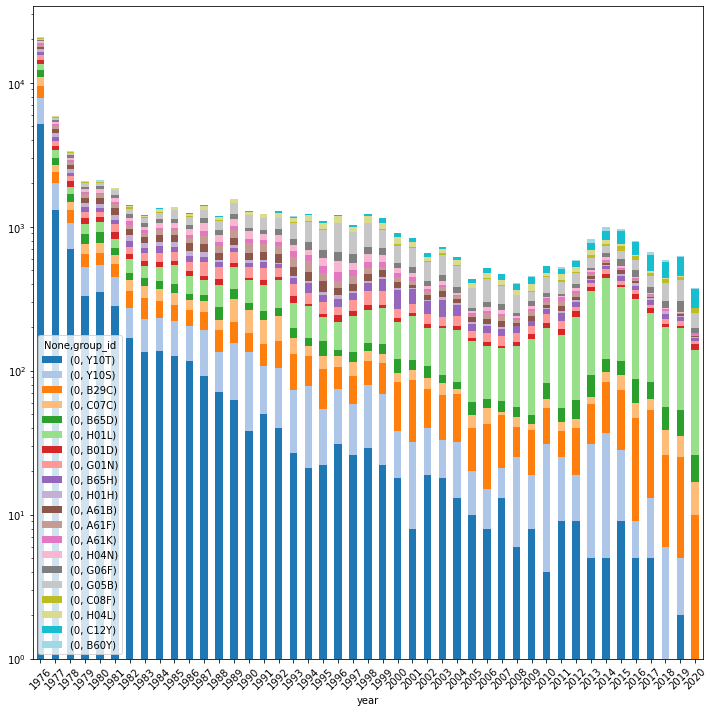

In [79]:
fig, ax = plt.subplots(figsize=(12, 12))

cmap = cm.get_cmap('tab20', len(CPCFULL_code_appearance_stacked_top.columns))
colors = cmap(range(len(CPCFULL_code_appearance_stacked_top.columns)))

CPCFULL_code_appearance_stacked_top.plot(ax=ax, kind='bar', stacked=True, color=colors, rot=45)
plt.yscale('log')

In [81]:
CPCFULL_code_appearance_stacked_top.sum().sum()

72117.0

## The distribution of CPC codes per inventor

In [54]:
def remove_none(x: set) -> set:
    if None in x:
        x.remove(None)
    return x

CPCFULL_inventor = ddf.map_partitions(lambda x: x[['inventor_id', 'cpc_subgroup_id']].drop_duplicates().\
                                      groupby('inventor_id').\
                                      agg({'cpc_subgroup_id': lambda x: remove_none(set(x))})).\
                                      compute()
CPCFULL_inventor = CPCFULL_inventor.groupby('inventor_id').sum()
CPCFULL_inventor

,cpc_subgroup_id
inventor_id,
3930273-1,"{A61G7/0507, A61G7/0509}"
3930274-1,{B63B7/085}
3930275-1,"{B29C65/04, B29C51/267, B29K2027/06, B29C66/82..."
3930276-1,"{B60S3/004, B65G19/02, Y10S15/02}"
3930277-1,"{E01H1/0854, B62B3/08, A47L9/325, B62B3/12}"
...,...
RE48223-1,{}
RE48230-3,{}
RE48234-1,{}


In [63]:
def get_len(x: set):
    if isinstance(x, set):
        return int(len(x))
    else:
        0
    
CPCFULL_inventor["cpc_subgroup_id_count"] = CPCFULL_inventor['cpc_subgroup_id'].apply(lambda x: get_len(x))

<AxesSubplot:xlabel='cpc_subgroup_id_count', ylabel='Count'>

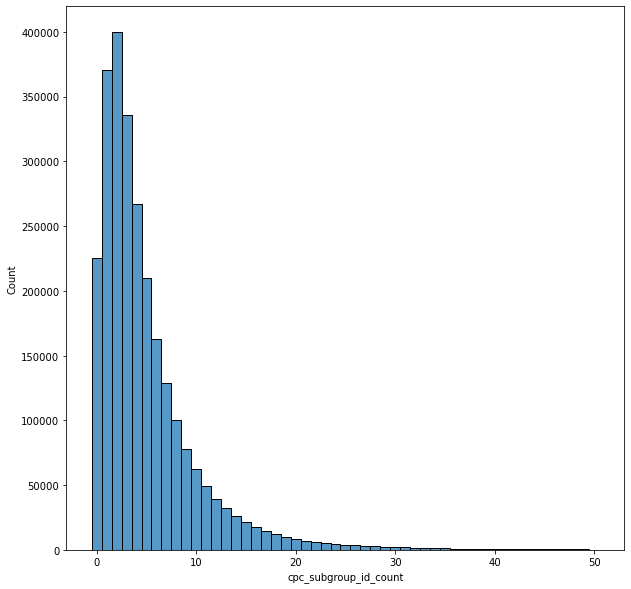

In [65]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.histplot(CPCFULL_inventor["cpc_subgroup_id_count"], bins=51, binrange=(0,50), discrete=True)

## The distribution of the number of codes per patent given the presence of a fresh code

In [67]:
CPCFULL_birth = ddf.map_partitions(lambda x: x[['cpc_subgroup_id', 'patent_date']].\
                                       drop_duplicates().groupby('cpc_subgroup_id').min()).compute()
CPCFULL_birth = CPCFULL_birth.groupby('cpc_subgroup_id').min()
CPCFULL_birth

,patent_date
cpc_subgroup_id,
A01B1/00,1977-01-11
A01B1/02,1979-01-23
A01B1/022,1976-11-23
A01B1/024,1980-02-12
A01B1/026,1977-09-27
...,...
Y10T83/9495,1976-04-06
Y10T83/9498,1976-03-09
Y10T83/95,1976-01-13


In [84]:
def month_diff(a, b):
    return 12 * (a.dt.year - b.dt.year) + (a.dt.month - b.dt.month)

def year_diff(a, b):
    return a.dt.year - b.dt.year

# subgroup_id is CPC full code
# group_id is CPC 4-digit code

CPCFULL_patent = ddf.map_partitions(lambda x: x[['cpc_subgroup_id', 'cpc_group_id', 'patent_date']].\
                                    reset_index().
                                    drop_duplicates().set_index('index'))
CPCFULL_patent = CPCFULL_patent.merge(
                      CPCFULL_birth, 
                      how='inner', left_on='cpc_subgroup_id', right_index=True, suffixes=['_actual','_birth']
    )
CPCFULL_patent['cpc_age'] = year_diff(CPCFULL_patent['patent_date_actual'], CPCFULL_patent['patent_date_birth'])
CPCFULL_patent = CPCFULL_patent.persist()

CPCFULL_patent.compute()

,cpc_subgroup_id,cpc_group_id,patent_date_actual,patent_date_birth,cpc_age
index,,,,,
3930271,A63B71/146,A63B,1976-01-06,1976-01-06,0
3931647,A63B71/146,A63B,1976-01-13,1976-01-06,0
3930272,A47D7/02,A47D,1976-01-06,1976-01-06,0
3934282,A47D7/02,A47D,1976-01-27,1976-01-06,0
3930272,Y10T403/32451,Y10T,1976-01-06,1976-01-06,0
...,...,...,...,...,...
10757848,H05F3/04,H05F,2020-08-25,1976-01-27,44
10757849,H05K2201/0358,H05K,2020-08-25,1980-10-07,40
10757849,H05K2203/1178,H05K,2020-08-25,1977-12-06,43


In [85]:
CPCFULL_birth_dates = CPCFULL_patent[['cpc_subgroup_id', 'patent_date_birth']].drop_duplicates().compute()
CPCFULL_birth_dates

,cpc_subgroup_id,patent_date_birth
index,,
3930271,A63B71/146,1976-01-06
3930272,A47D7/02,1976-01-06
3930272,Y10T403/32451,1976-01-06
3930273,A61G7/0507,1976-01-06
3930273,A61G7/0509,1976-01-06
...,...,...
10754308,G05B2219/40481,2020-08-25
10754890,G06F16/65,2020-08-25
10755824,B01D23/10,2020-08-25


In [86]:
CPCFULL_patent = CPCFULL_patent.map_partitions(
        lambda x: x.groupby('index').agg({'cpc_age': 'min', 
                                          'cpc_subgroup_id': 'nunique', 
                                          'cpc_group_id': 'nunique', 
                                          'patent_date_actual': 'first'})
    )
CPCFULL_patent

,cpc_age,cpc_subgroup_id,cpc_group_id,patent_date_actual
npartitions=537,,,,
,int64,int64,int64,datetime64[ns]
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


In [87]:
CPCFULL_patent_df = CPCFULL_patent.compute()
CPCFULL_patent_df

,cpc_age,cpc_subgroup_id,cpc_group_id,patent_date_actual
index,,,,
3930271,0,1,1,1976-01-06
3930272,0,2,2,1976-01-06
3930273,0,2,1,1976-01-06
3930274,0,1,1,1976-01-06
3930275,0,19,5,1976-01-06
...,...,...,...,...
10757847,32,9,4,2020-08-25
10757848,36,6,3,2020-08-25
10757849,33,6,1,2020-08-25


Text(0.5, 1.0, 'Distribution of patents with a given minimal CPC age')

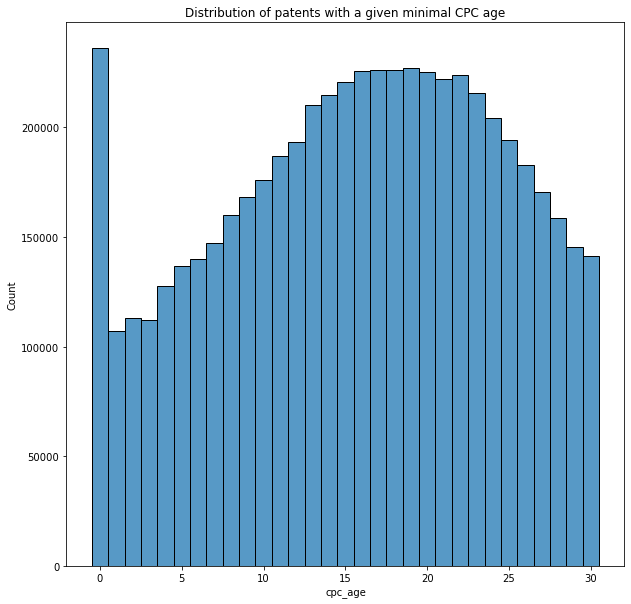

In [88]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.histplot(CPCFULL_patent_df['cpc_age'], bins=31, binrange=(0,30), discrete=True)
plt.title('Distribution of patents with a given minimal CPC age')

In [89]:
num_cpc_full_codes_year = {}
for year in [1990, 2000, 2010, 2020]:
    num_cpc_full_codes_year[year] = len(CPCFULL_birth_dates.query(f"patent_date_birth < {year}"))

print("The growth in the average number of full CPC codes w.r.t. baseline")
print(f"The baseline is 1990 and at this point we have {num_cpc_full_codes_year[1990]} full CPC codes")
for year in num_cpc_full_codes_year.keys():
    print(f"Increase in {year} w.r.t. 1990:", num_cpc_full_codes_year[year] / num_cpc_full_codes_year[1990])

The growth in the average number of full CPC codes w.r.t. baseline
The baseline is 1990 and at this point we have 174270 full CPC codes
Increase in 1990 w.r.t. 1990: 1.0
Increase in 2000 w.r.t. 1990: 1.1771733516956446
Increase in 2010 w.r.t. 1990: 1.2714867733976014
Increase in 2020 w.r.t. 1990: 1.3759338956791185


In [90]:
CPCFULL_patent_df.query("patent_date_actual > 1980 & patent_date_actual < 1990").groupby('cpc_age').mean()



,cpc_subgroup_id,cpc_group_id
cpc_age,,
0,5.927589,2.232733
1,5.453066,2.213600
2,5.137035,2.168243
3,4.571723,2.093078
4,3.495111,1.829686
5,3.442321,1.819594
6,3.435606,1.817163
7,3.381547,1.799419
8,3.266244,1.766648


In [91]:
CPCFULL_patent_df

,cpc_age,cpc_subgroup_id,cpc_group_id,patent_date_actual
index,,,,
3930271,0,1,1,1976-01-06
3930272,0,2,2,1976-01-06
3930273,0,2,1,1976-01-06
3930274,0,1,1,1976-01-06
3930275,0,19,5,1976-01-06
...,...,...,...,...
10757847,32,9,4,2020-08-25
10757848,36,6,3,2020-08-25
10757849,33,6,1,2020-08-25


Text(0.5, 1.0, 'Average number of Full CPC codes per patent as a function of the age of the youngest CPC code')

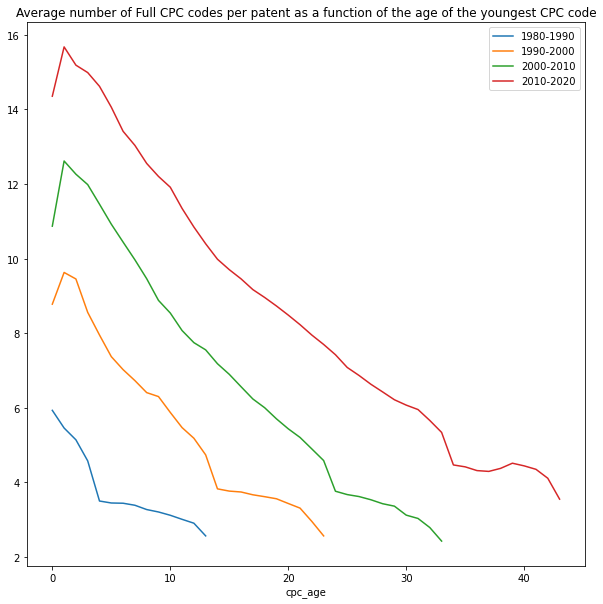

In [92]:
fig, ax = plt.subplots(figsize=(10, 10))

CPCFULL_patent_df.query("patent_date_actual > 1980 & patent_date_actual < 1990").groupby('cpc_age').mean()['cpc_subgroup_id'].plot(ax=ax)
CPCFULL_patent_df.query("patent_date_actual > 1990 & patent_date_actual < 2000").groupby('cpc_age').mean()['cpc_subgroup_id'].plot(ax=ax)
CPCFULL_patent_df.query("patent_date_actual > 2000 & patent_date_actual < 2010").groupby('cpc_age').mean()['cpc_subgroup_id'].plot(ax=ax)
CPCFULL_patent_df.query("patent_date_actual > 2010 & patent_date_actual < 2020").groupby('cpc_age').mean()['cpc_subgroup_id'].plot(ax=ax)

plt.legend(["1980-1990", "1990-2000", "2000-2010", "2010-2020"])
plt.title("Average number of Full CPC codes per patent as a function of the age of the youngest CPC code")

Text(0.5, 1.0, 'Average number of CPC 4-digit codes per patent as a function of the age of the youngest full CPC code')

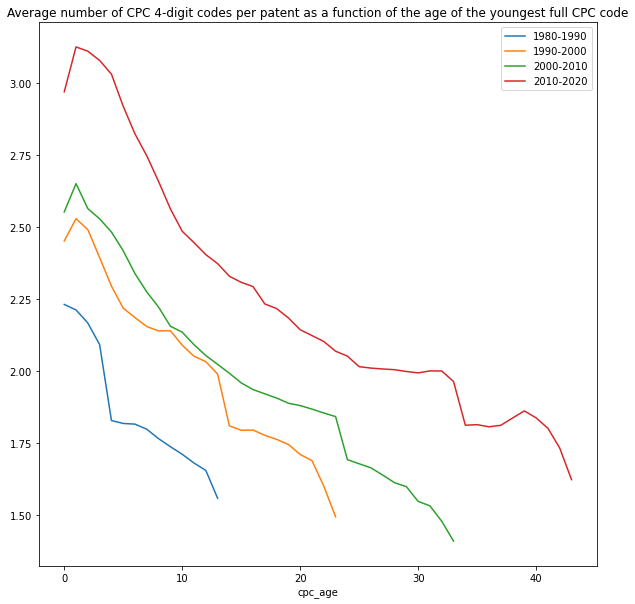

In [93]:
fig, ax = plt.subplots(figsize=(10, 10))

CPCFULL_patent_df.query("patent_date_actual > 1980 & patent_date_actual < 1990").groupby('cpc_age').mean()['cpc_group_id'].plot(ax=ax)
CPCFULL_patent_df.query("patent_date_actual > 1990 & patent_date_actual < 2000").groupby('cpc_age').mean()['cpc_group_id'].plot(ax=ax)
CPCFULL_patent_df.query("patent_date_actual > 2000 & patent_date_actual < 2010").groupby('cpc_age').mean()['cpc_group_id'].plot(ax=ax)
CPCFULL_patent_df.query("patent_date_actual > 2010 & patent_date_actual < 2020").groupby('cpc_age').mean()['cpc_group_id'].plot(ax=ax)

plt.legend(["1980-1990", "1990-2000", "2000-2010", "2010-2020"])
plt.title("Average number of CPC 4-digit codes per patent as a function of the age of the youngest full CPC code")


In [94]:
ddf_citation = dask.read_parquet("/patent-analysis/datasets/api/*-citations.parquet")

In [95]:
ddf_citation.head()

,patent_date,cited_patent_number,cited_patent_date,cited_patent_sequence,citedby_patent_number,citedby_patent_date
3930271,1976-01-06,2379430,NaT,0,5135226,1992-08-04
3930271,1976-01-06,2379430,NaT,0,5592695,1997-01-14
3930271,1976-01-06,2379430,NaT,0,5621918,1997-04-22
3930271,1976-01-06,2379430,NaT,0,5624296,1997-04-29
3930271,1976-01-06,2379430,NaT,0,5675839,1997-10-14


In [96]:
len(ddf_citation)

2760824809